In [21]:
import pyspark
import pyspark.sql  as pyspark_sql
import pyspark.sql.types as pyspark_types
import pyspark.sql.functions  as pyspark_functions
from pyspark import SparkContext, SparkConf
from pyspark.sql.functions import col, sum as sum_
from pyspark.sql.window import Window
from pyspark.sql.functions import coalesce, col, lag, lead, count
from pyspark.sql.functions import mean

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = pyspark_sql.SparkSession.builder.getOrCreate()

In [3]:
# Load the dataset
cmn_data = spark.read.csv("dataset/col_mat_nuw_output.csv", header=None, inferSchema=True)

In [4]:
cmn_data.printSchema()

root
 |-- _c0: double (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: date (nullable = true)
 |-- _c3: date (nullable = true)



In [5]:
cmn_data.show()

+--------------------+--------------+----------+----------+
|                 _c0|           _c1|       _c2|       _c3|
+--------------------+--------------+----------+----------+
|1.969834395781014...|Colombo Proper|2019-01-01|2019-01-02|
|2.625522171968594...|Colombo Proper|2019-01-02|2019-01-03|
|9.852118897938794E-5|Colombo Proper|2019-01-03|2019-01-04|
|2.099320518114242E-4|Colombo Proper|2019-01-04|2019-01-05|
|1.785337298892930...|Colombo Proper|2019-01-05|2019-01-06|
|1.082296700235670...|Colombo Proper|2019-01-06|2019-01-07|
|3.926829280477309...|Colombo Proper|2019-01-07|2019-01-08|
|9.153156350685351E-5|Colombo Proper|2019-01-08|2019-01-09|
|1.205978992853015...|Colombo Proper|2019-01-09|2019-01-10|
|1.297723562983258...|Colombo Proper|2019-01-10|2019-01-11|
|2.239188166801278...|Colombo Proper|2019-01-11|2019-01-12|
|1.569418094178759...|Colombo Proper|2019-01-12|2019-01-13|
|                NULL|Colombo Proper|2019-01-13|2019-01-14|
|1.336291906862603...|Colombo Proper|201

In [6]:
# Define the new column names
column_names = ['HCHO Reading', 'Location', 'Current Date', 'Next Date']

# Rename the columns
for i, new_name in enumerate(column_names):
    cmn_data = cmn_data.withColumnRenamed(cmn_data.columns[i], new_name)

cmn_data.show()

+--------------------+--------------+------------+----------+
|        HCHO Reading|      Location|Current Date| Next Date|
+--------------------+--------------+------------+----------+
|1.969834395781014...|Colombo Proper|  2019-01-01|2019-01-02|
|2.625522171968594...|Colombo Proper|  2019-01-02|2019-01-03|
|9.852118897938794E-5|Colombo Proper|  2019-01-03|2019-01-04|
|2.099320518114242E-4|Colombo Proper|  2019-01-04|2019-01-05|
|1.785337298892930...|Colombo Proper|  2019-01-05|2019-01-06|
|1.082296700235670...|Colombo Proper|  2019-01-06|2019-01-07|
|3.926829280477309...|Colombo Proper|  2019-01-07|2019-01-08|
|9.153156350685351E-5|Colombo Proper|  2019-01-08|2019-01-09|
|1.205978992853015...|Colombo Proper|  2019-01-09|2019-01-10|
|1.297723562983258...|Colombo Proper|  2019-01-10|2019-01-11|
|2.239188166801278...|Colombo Proper|  2019-01-11|2019-01-12|
|1.569418094178759...|Colombo Proper|  2019-01-12|2019-01-13|
|                NULL|Colombo Proper|  2019-01-13|2019-01-14|
|1.33629

In [7]:
# Data description of HCHO Reading column
cmn_data.describe('HCHO Reading').show()

+-------+--------------------+
|summary|        HCHO Reading|
+-------+--------------------+
|  count|                3059|
|   mean|1.200429799620477...|
| stddev|1.009218095609297E-4|
|    min|-2.59296176552668...|
|    max|8.997101837438971E-4|
+-------+--------------------+



In [8]:
unique_locations_count = cmn_data.select("Location").distinct().count()
print(f"Number of unique values in the 'Location' column: {unique_locations_count}")
cmn_data.select("Location").distinct().show()

Number of unique values in the 'Location' column: 3
+-------------------+
|           Location|
+-------------------+
|   Deniyaya, Matara|
|     Colombo Proper|
|Nuwara Eliya Proper|
+-------------------+



In [9]:
# Checking the sum of the Null values
cmn_data.select(*[sum_(col(c).isNull().cast("int")).alias(c) for c in cmn_data.columns]).show()


+------------+--------+------------+---------+
|HCHO Reading|Location|Current Date|Next Date|
+------------+--------+------------+---------+
|        2419|       0|           0|        0|
+------------+--------+------------+---------+



In [10]:
# # Define the window specification for backward fill
# backward_windowSpec = Window.orderBy("Current Date")

# # Use lag to get the previous value in 'HCHO Reading'
# previous_value = lag("HCHO Reading", 1, None).over(backward_windowSpec)

# # Replace nulls in 'HCHO Reading' with the previous non-null value
# # We're using coalesce to keep the current value if it's not null or replace it with the previous value if it is null
# cmn_data = cmn_data.withColumn("HCHO Reading", coalesce("HCHO Reading", previous_value))

In [11]:
# # Define the window specification with the correct ordering column
# windowSpec = Window.orderBy("Current Date")  # Adjust if there's a more appropriate column

# # Use lead to get the next value in 'HCHO Reading'
# next_value = lead("HCHO Reading", 1, None).over(windowSpec)

# # Replace nulls in 'HCHO Reading' with the next non-null value
# cmn_data = cmn_data.withColumn("HCHO Reading", coalesce("HCHO Reading", next_value))


In [12]:
# Initialize a counter for null values
null_count = cmn_data.filter(col("HCHO Reading").isNull()).count()

# Continue the process until there are no nulls left
while null_count > 0:
    # Define the window specifications
    backward_windowSpec = Window.orderBy("Current Date")
    forward_windowSpec = Window.orderBy("Current Date")
    
    # Use lag to carry the last observation forward
    previous_value = lag("HCHO Reading", 1).over(backward_windowSpec)
    cmn_data = cmn_data.withColumn("HCHO Reading", coalesce("HCHO Reading", previous_value))
    
    # Use lead to carry the next observation backward
    next_value = lead("HCHO Reading", 1).over(forward_windowSpec)
    cmn_data = cmn_data.withColumn("HCHO Reading", coalesce("HCHO Reading", next_value))
    
    # Update the null count
    null_count = cmn_data.filter(col("HCHO Reading").isNull()).count()

In [13]:
cmn_data.select(*[sum_(col(c).isNull().cast("int")).alias(c) for c in cmn_data.columns]).show()

+------------+--------+------------+---------+
|HCHO Reading|Location|Current Date|Next Date|
+------------+--------+------------+---------+
|           0|       0|           0|        0|
+------------+--------+------------+---------+



In [15]:
dataset_length = cmn_data.count()
print("The length of the dataset is:", dataset_length)

The length of the dataset is: 5478


In [16]:
cmn_data = cmn_data.dropDuplicates()

In [17]:
dataset_length = cmn_data.count()
print("The length of the dataset is:", dataset_length)

The length of the dataset is: 5478


In [18]:
# Convert the PySpark DataFrame to a Pandas DataFrame
cmn_data = cmn_data.toPandas()
cmn_data

,HCHO Reading,Location,Current Date,Next Date
0,0.000197,Colombo Proper,2019-01-01,2019-01-02
1,0.000197,"Deniyaya, Matara",2019-01-01,2019-01-02
2,0.000263,Nuwara Eliya Proper,2019-01-01,2019-01-02
3,0.000263,Colombo Proper,2019-01-02,2019-01-03
4,0.000006,"Deniyaya, Matara",2019-01-02,2019-01-03
...,...,...,...,...
5473,0.000080,Colombo Proper,2023-12-31,2024-01-01
5474,0.000080,"Deniyaya, Matara",2023-12-31,2024-01-01
5475,0.000080,Nuwara Eliya Proper,2023-12-31,2024-01-01
5476,0.000254,Colombo Proper,2022-03-07,2022-03-08


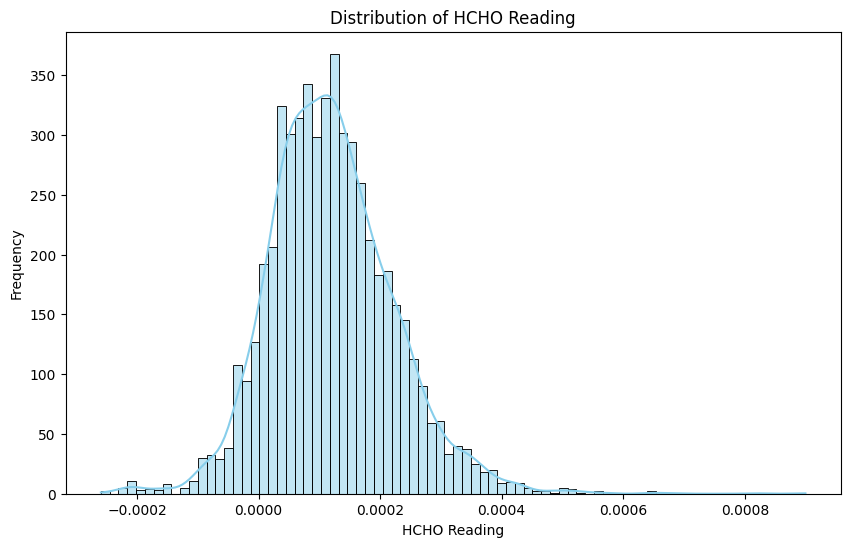

In [19]:
# Plot the distribution of the "HCHO Reading" column
plt.figure(figsize=(10, 6))
sns.histplot(cmn_data["HCHO Reading"], kde=True, color='skyblue')
plt.title('Distribution of HCHO Reading')
plt.xlabel('HCHO Reading')
plt.ylabel('Frequency')
plt.show()

In [20]:
cmn_data.to_csv("preprocessed_dataset/col_mat_nuw_pp.csv", index=False)